# Goal

* Initial testing, assessment, and debugging of SIPSim qSIP data
* **Parameters**
  * 12C control & 13C treatment gradients
  * n-reps = 3 (n-total = 6)
  * % atom excess = 100%
  * % taxa with incorporation = 10%

# Init

In [1]:
import os
import glob
import re
import nestly
%load_ext rpy2.ipython

In [2]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Nestly

* assuming fragments already simulated

In [3]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/'
buildDir = os.path.join(workDir, 'default_rep3')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags.pkl'
genomeIndex = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/genome_index.txt'

# simulation parameters
prefrac_comm_abundance = '1e9'
n_gradient_reps = 3
nprocs = 24

In [30]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('abs', [prefrac_comm_abundance])

## set params
nest.add('percIncorp', [100], create_dir=False)
nest.add('percTaxa', [10], create_dir=False)
nest.add('n_gradient_reps', [n_gradient_reps], create_dir=False)
nest.add('np', [nprocs], create_dir=False)


### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('genomeIndex', [genomeIndex], create_dir=False)

# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [31]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

echo '#-- SIPSim pipeline --#'
echo '# converting fragments to KDE'
SIPSim fragment_KDE \
    {fragFile} \
    > ampFrags_KDE.pkl
    
echo '# adding diffusion'    
SIPSim diffusion \
    ampFrags_KDE.pkl \
    --np {np} \
    > ampFrags_KDE_dif.pkl    

echo '# adding DBL contamination'
SIPSim DBL \
    ampFrags_KDE_dif.pkl \
    --np {np} \
    > ampFrags_KDE_dif_DBL.pkl      
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  --n_reps 3 \
  > {percTaxa}_{percIncorp}_{n_gradient_reps}.config

echo '# making community file'
!cd $workDir; \
    SIPSim communities \
    --config {percTaxa}_{percIncorp}_{n_gradient_reps}.config \
    {genomeIndex} \
    > comm.txt    

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    ampFrags_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}_{n_gradient_reps}.config \
    --comm comm.txt \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc.pkl
    
echo '# calculating BD shift from isotope incorporation'
SIPSim BD_shift \
    ampFrags_KDE_dif_DBL.pkl \
    ampFrags_KDE_dif_DBL_inc.pkl \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc_BD-shift.pkl

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    comm.txt > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
    
    
echo '# Removing control.json file'    
rm -f control.json

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP_rep3/SIPSimRun.sh


In [32]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d qSIP_rep3 --log-file log.txt -j 1

2016-01-18 10:51:23,348 * INFO * Template: ./SIPSimRun.sh
2016-01-18 10:51:23,349 * INFO * [86828] Started ./SIPSimRun.sh in qSIP_rep3/1e9
2016-01-18 11:25:40,332 * INFO * [86828] qSIP_rep3/1e9 Finished with 0


# qSIP

In [278]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('abs', [prefrac_comm_abundance])
nest.add('sim_rep', range(10))

# unvarying params
expDesignFile = os.path.join(buildDir, 'exp_design.txt')
nest.add('expDesignFile', [expDesignFile], create_dir=False)
nest.add('buildDir', [buildDir], create_dir=False)

# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'qSIPRun.sh')

In [279]:
%%writefile $expDesignFile

1	control
2	treatment
3	control
4	treatment
5	control
6	treatment

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/exp_design.txt


In [280]:
%%writefile $bashFile
#!/bin/bash

# qSIP
SIPSim qSIP \
    --reps 3 \
    {buildDir}/{abs}/OTU_abs1e9.txt {buildDir}/{abs}/OTU_abs1e9_PCR_sub.txt \
    > OTU_abs1e9_PCR_sub_qSIP.txt
        
# atom excess
SIPSim qSIP_atomExcess \
    OTU_abs1e9_PCR_sub_qSIP.txt \
    {expDesignFile} \
    --np 14 \
    > OTU_abs1e9_PCR_sub_qSIP_atom.txt 

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/qSIPRun.sh


In [281]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d default_rep3 --log-file log.txt -j 2

2016-01-20 19:53:36,569 * INFO * Template: ./qSIPRun.sh
2016-01-20 19:53:36,571 * INFO * [173428] Started ./qSIPRun.sh in default_rep3/1e9/7
2016-01-20 19:53:36,573 * INFO * [173429] Started ./qSIPRun.sh in default_rep3/1e9/0
^C2016-01-20 20:03:58,274 * WARNING * SIGINT received; send again to terminate
2016-01-20 20:03:58,284 * WARNING * [173429] default_rep3/1e9/0 Finished with non-zero exit status 1
    inferred_type = lib.infer_dtype(sample)
KeyboardInterrupt
    return pivot(self, index=index, columns=columns, values=values)
  File "/opt/anaconda/lib/python2.7/site-packages/pandas/core/reshape.py", line 328, in pivot
    return indexed.unstack(columns)
  File "/opt/anaconda/lib/python2.7/site-packages/pandas/core/series.py", line 1957, in unstack
    {axis: [new_index, indexer]}, fill_value=fill_value, copy=copy)
  File "/opt/anaconda/lib/python2.7/site-packages/pandas/core/generic.py", line 1861, in _reindex_with_indexers
    for axis in sorted(reindexers.keys()):
KeyboardInterru

# Analyzing the results

## Plotting total abs abundance (from OTU table)

In [189]:
%%R -i buildDir -i prefrac_comm_abundance 

OTU_file = file.path(buildDir, prefrac_comm_abundance, 'OTU_abs1e9.txt')

df.OTU = read.delim(OTU_file, sep='\t') %>%
    group_by(library, fraction, BD_mid) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = library %>% as.character) 

df.OTU %>% head(n=3)

Source: local data frame [3 x 4]

  library    fraction BD_mid total_count
    (chr)      (fctr)  (dbl)       (int)
1       1 1.660-1.663  1.661       94176
2       1 1.663-1.665  1.664       62854
3       1 1.665-1.671  1.668      200310


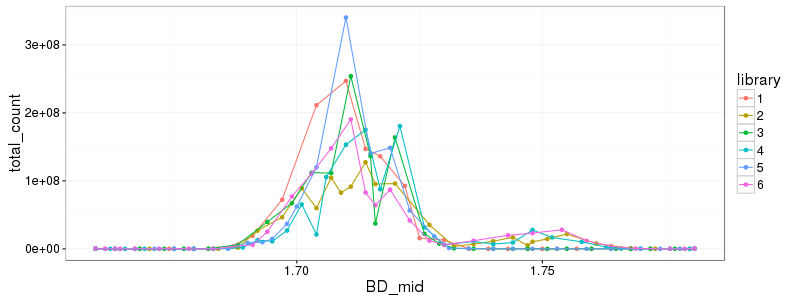

In [190]:
%%R -w 800 -h 300

ggplot(df.OTU, aes(BD_mid, total_count, color=library)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## qPCR values

In [277]:
qPCR_files = !find $buildDir -maxdepth 3 -name "OTU_abs1e9_PCR_sub_qSIP.txt"
qPCR_files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/0/OTU_abs1e9_PCR_sub_qSIP.txt']

In [204]:
%%R -i qPCR_files
# loading files
df = list()
for (x in qPCR_files){
    f = gsub('/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/([0-9.]+)/.+', '\\1', x)
    df[[f]] = read.delim(x, sep='\t') %>%
        distinct(library, fraction) %>%
        select(-taxon) %>%
        as.data.frame()
    }
df = do.call('rbind', df)
df$file = gsub('\\.[0-9]+$', '', rownames(df))
rownames(df) = 1:nrow(df)
df = df %>%
    mutate(exp_design = ifelse(library %% 2 == 0, 'treatment', 'control'),
           library = library %>% as.character,
           file = file %>% as.numeric)
df %>% head(n=3)

  library   fraction BD_min BD_mid BD_max count  rel_abund total_qPCR_copies
1       1 -inf-1.660   -Inf  1.659  1.659   291 0.01319010            273922
2       2 -inf-1.660   -Inf  1.659  1.659   209 0.01315458            209813
3       3 -inf-1.660   -Inf  1.659  1.659   269 0.01264217            635209
  prop_abs_abund file exp_design
1           3613    0    control
2             25    0  treatment
3            112    0    control


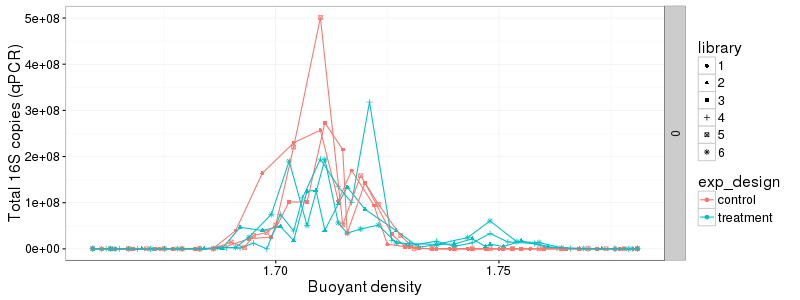

In [206]:
%%R -w 800 -h 300

ggplot(df, aes(BD_mid, total_qPCR_copies, color=exp_design, group=library, shape=library)) +
    geom_point() +
    geom_line() +
    facet_grid(file ~ .) +
    #scale_y_log10() +
    labs(x = 'Buoyant density', y='Total 16S copies (qPCR)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Scaling to proportion of total (as in Hungate et al., 2015)

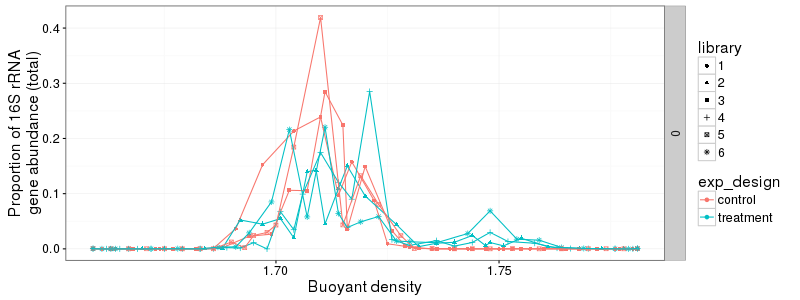

In [207]:
%%R -w 800 -h 300

df = df %>%
    group_by(file, library) %>%
    mutate(frac_total_qPCR_copies = total_qPCR_copies / sum(total_qPCR_copies)) %>%
    ungroup() 

ggplot(df, aes(BD_mid, frac_total_qPCR_copies, color=exp_design, group=library, shape=library)) +
    geom_point() +
    geom_line() +
    facet_grid(file ~ .) +
    labs(x = 'Buoyant density', y='Proportion of 16S rRNA\ngene abundance (total)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Plotting % atom excess

In [268]:
qPCR_files = !find $buildDir -maxdepth 3 -name "OTU_abs1e9_PCR_sub_qSIP_atom.txt"
qPCR_files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/0/OTU_abs1e9_PCR_sub_qSIP_atom.txt']

In [269]:
%%R -i qPCR_files
# loading files

df.atom = list()
for (x in qPCR_files){
    f = gsub('/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/([0-9.]+)/.+', '\\1', x)
    df.atom[[f]] = read.delim(x, sep='\t') 
    }
df.atom = do.call('rbind', df.atom)
df.atom$file = gsub('\\.[0-9]+$', '', rownames(df.atom))
rownames(df.atom) = 1:nrow(df.atom)
df.atom %>% head(n=3)

                                 taxon  control treatment      BD_diff
1       Acaryochloris_marina_MBIC11017 1.722889  1.719015 -0.003874331
2 Acetobacter_pasteurianus_IFO_3283-03 1.728614  1.718573 -0.010041049
3       Acetobacterium_woodii_DSM_1030 1.733265  1.711215 -0.022049984
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.6417248   308.0093         317.6638     307.3167          -0.07094465
2  0.7001477   308.0383         317.6637     306.2490          -0.18382928
3  0.7475993   308.0618         317.6635     304.1428          -0.40362624
  atom_CI_low atom_CI_high file
1   -0.538600     0.294394    0
2   -0.501856    -0.156085    0
3   -1.257550    -0.353358    0


## density shift

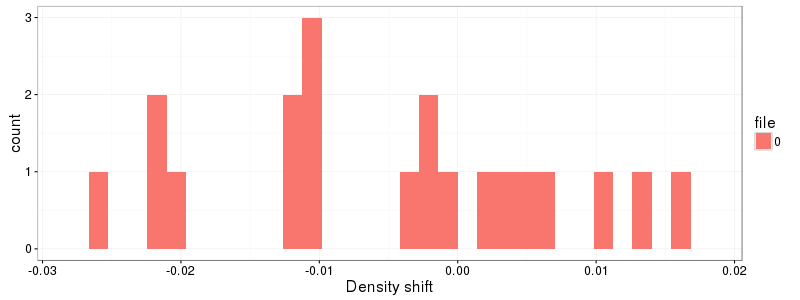

In [270]:
%%R -w 800 -h 300

ggplot(df.atom, aes(BD_diff, fill=file)) +
    geom_histogram() +
    labs(x='Density shift') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Atom fraction excess

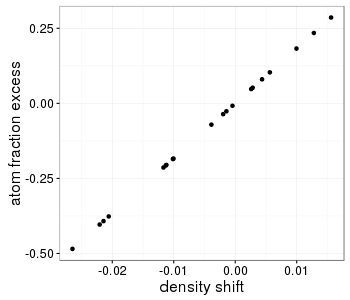

In [271]:
%%R -w 350 -h 300

ggplot(df.atom, aes(BD_diff, atom_fraction_excess)) +
    geom_point() +
    labs(x='density shift', y='atom fraction excess') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [272]:
%%R
ret = lm(atom_fraction_excess ~ BD_diff, data=df.atom)
print(ret)
summary(ret)


Call:
lm(formula = atom_fraction_excess ~ BD_diff, data = df.atom)

Coefficients:
(Intercept)      BD_diff  
  4.037e-05    1.831e+01  


Call:
lm(formula = atom_fraction_excess ~ BD_diff, data = df.atom)

Residuals:
       Min         1Q     Median         3Q        Max 
-8.887e-05 -4.129e-05 -2.865e-05  4.906e-05  1.392e-04 

Coefficients:
             Estimate Std. Error   t value Pr(>|t|)    
(Intercept) 4.037e-05  1.500e-05     2.692   0.0149 *  
BD_diff     1.831e+01  1.176e-03 15574.798   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.184e-05 on 18 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 2.426e+08 on 1 and 18 DF,  p-value: < 2.2e-16



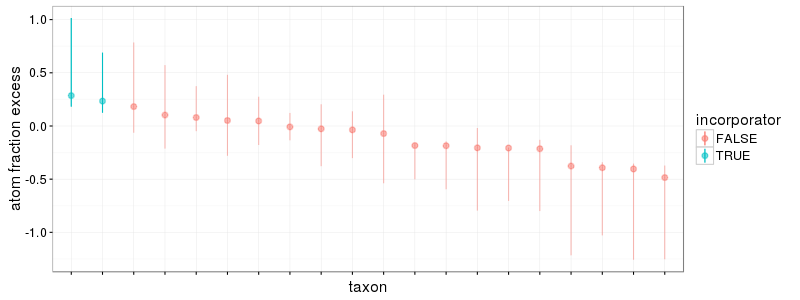

In [276]:
%%R -w 800 -h 300

df.atom = df.atom %>%
    mutate(incorporator = ifelse(atom_CI_low > 0, TRUE, FALSE)) 

df.atom$taxon = reorder(df.atom$taxon, -df.atom$atom_fraction_excess)

ggplot(df.atom, aes(taxon, atom_fraction_excess, color=incorporator,
                    ymin=atom_CI_low, ymax=atom_CI_high)) +
    geom_point(alpha=0.1, size=0.2) +
    geom_pointrange(alpha=0.5) +
    geom_linerange(data=df.atom %>% filter(incorporator==TRUE)) +
    labs(y = 'atom fraction excess') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )

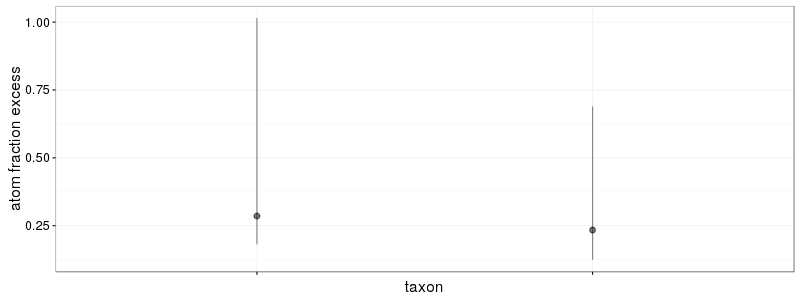

In [274]:
%%R -w 800 -h 300

df.atom.inc = df.atom %>%
    mutate(incorporator = ifelse(atom_CI_low > 0, TRUE, FALSE)) %>%
    filter(incorporator == TRUE)

df.atom.inc$taxon = reorder(df.atom.inc$taxon, -df.atom.inc$atom_fraction_excess)

ggplot(df.atom.inc, aes(taxon, atom_fraction_excess,
                    ymin=atom_CI_low, ymax=atom_CI_high)) +
    geom_pointrange(alpha=0.5) +
    labs(y = 'atom fraction excess') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )

In [275]:
%%R
n_incorp = df.atom %>%
    filter(incorporator == TRUE) %>%
    nrow()

n_taxa = df.atom %>% nrow
perc = round(n_incorp / n_taxa * 100, 2)

cat('Number of identified incorporators: ', n_incorp, ' (', perc, '% of taxa)\n', sep='')

Number of identified incorporators: 2 (10% of taxa)


# Comparing BD shift between qSIP and known

`SIPSim BD_shift` **vs** `SIPSim qSIP_atomExcess`

# DEBUG: Calculate atom excess from BD shift

In [254]:
W_light = 1.7
W_heavy = 1.7 + 0.02

def GC_content(W_light):
    G = 1/0.083506 * (W_light - 1.646057)
    return G

def G2M_light(G):
    M_light = 0.496 * G + 307.691
    return M_light

#def M_light2M_heavyMax(M_light):
#    M_heavyMax = 12.07747 + M_light
#    return M_heavyMax

def M_light2M_heavyMax(G, M_light):   # 13C
    M_heavyMax = -0.4987282 * G + 9.974564 + M_light
    return M_heavyMax

def calc_M_lab(Z, W_light, M_light):
    M_lab = (Z / W_light + 1) * M_light
    return M_lab

def calc_atom_excess(M_lab, M_light, M_heavyMax):
    x = M_lab - M_light
    y = M_heavyMax - M_light
    A_carbon = x / y * (1-0.01111233)
    return A_carbon

def W2atomFrac(W_light, W_heavy):
    Z = W_heavy - W_light
    G = GC_content(W_light)
    M_light = G2M_light(G)
    M_heavyMax = M_light2M_heavyMax(G, M_light)
    M_lab = calc_M_lab(Z, W_light, M_light)
    atomX = calc_atom_excess(M_lab, M_light, M_heavyMax)
    return atomX


# run
W2atomFrac(W_light, W_heavy)

0.371244191475315